# Assess model fits
Reviewer comment: "To substantiate the core claim, the authors need to provide considerably more details on the spectral fits, such as
1. plots of multiple example spectra with fits superimposed
2. distributions of fit r^2 statistics across electrodes, separately for baseline and encoding periods
3. distributions of number-of-peaks detected (which, I understand, is a free parameter), etc."

### Set path

In [1]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

## Set-up

### Imports

In [2]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from fooof import FOOOFGroup

In [3]:
# custom
import sys
sys.path.append(f"{PROJECT_PATH}/code")
from specparam_utils import compute_adj_r2


### Settings

In [4]:
# dataset details
PATIENTS = ['pat02','pat04','pat05','pat08','pat10','pat11','pat15','pat16',
            'pat17','pat19','pat20','pat21','pat22'] # subject IDs


In [5]:
# Matplotlib rcParams

# font/text size
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 16
rcParams['legend.fontsize'] = 12

# saving
rcParams['savefig.dpi'] = 300
rcParams['savefig.facecolor'] = 'w'

## Main

### Import results
r-squared values and number-of-peaks detected for each condition

In [6]:
# Import r-squared values for each aperiodic model across all conditions

# init
df = pd.DataFrame(columns=['material','memory','window','chan_idx','r_squared','n_peaks'])

# loop through all conditions
for material in ['words','faces']:
    for memory in ['hit','miss']:
        for window in ['pre', 'post']:

                # load spectral parameters for condition and add to df
                params = FOOOFGroup()
                params.load(f'{PROJECT_PATH}/data/ieeg_psd_param/psd_{material}_{memory}_{window}stim_params_knee')
                r_squared = compute_adj_r2(params)
                n_peaks = params.n_peaks_
                for chan_idx in range(len(params)):
                    row = pd.DataFrame([[material, memory, window, chan_idx, r_squared[chan_idx], n_peaks[chan_idx]]], 
                        columns=['material','memory','window','chan_idx','r_squared','n_peaks'])
                    df = pd.concat([df, row], ignore_index=True)
df[['r_squared','n_peaks']] = df[['r_squared','n_peaks']].apply(pd.to_numeric)
df

,material,memory,window,chan_idx,r_squared,n_peaks
0,words,hit,pre,0,0.992638,1
1,words,hit,pre,1,0.991367,1
2,words,hit,pre,2,0.992535,2
3,words,hit,pre,3,0.991625,1
4,words,hit,pre,4,0.989262,0
...,...,...,...,...,...,...
5367,faces,miss,post,670,0.979428,0
5368,faces,miss,post,671,0.984944,0
5369,faces,miss,post,672,0.982183,2
5370,faces,miss,post,673,0.984768,1


### 1. Example spectral fits
plots of multiple example spectra with fits superimposed


Response: here we plot an example spectum with the fit superimposed for each experimental condition: memory condition (hit v. miss), material condition (words v. faces), and trial window (pre-stimulus v. post-stimulus).

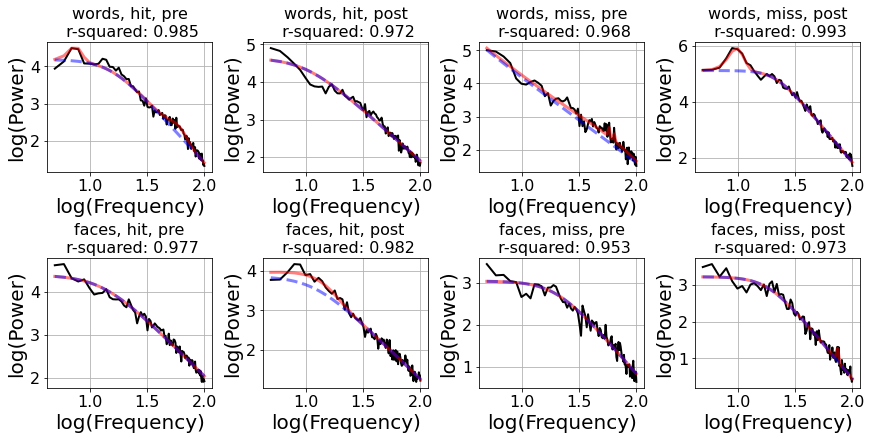

In [7]:
# plot spectral model fit for a random channel for eah condition


# create figure
fig, axes = plt.subplots(2,4, figsize=[12, 6], constrained_layout=True)
ii = 0

# loop through all conditions 
for material in ['words','faces']:
    for memory in ['hit','miss']:
        for window in ['pre', 'post']:

                # load spectral parameters for condition
                params = FOOOFGroup()
                params.load(f'{PROJECT_PATH}/data/ieeg_psd_param/psd_{material}_{memory}_{window}stim_params_knee')

                # get model for random condition and compute adjusted r-squared
                chan_idx = np.random.randint(len(params))
                model = params.get_fooof(chan_idx)
                r_squared = compute_adj_r2(params)[chan_idx]

                # plot model fit
                ax = np.ravel(axes)[ii]
                model.plot(plt_log=True, ax=ax)
                # ax = plt.gca()
                # ax.set_title(f"{material}, {memory}, {window}-stim\n r-squared: {r_squared:.3f}")
                ax.set_title(f"{material}, {memory}, {window}\n r-squared: {r_squared:.3f}")
                ax.get_legend().remove()
                ii += 1

### 2. Distribution of r-squared 
distributions of fit r^2 statistics across electrodes, separately for baseline and encoding periods


Response: The mean r-squared value across all spectra fit was 0.976. R-squared values were similar across all conditions.

In [8]:
# settings
colors = [np.array([1,133,113]) /255, np.array([166,97,26]) /255] # [np.array([128,205,193]) /255, np.array([223,194,125]) /255]
bin_edges = np.linspace(0, 1, 100)

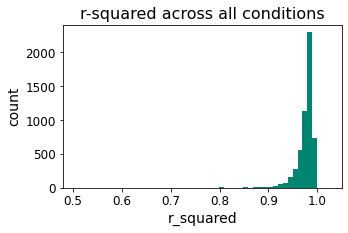

Mean r-squared: 	0.9761473675734591


In [9]:
# plot histogram of r-squared values (all conditions combined)
fig, ax = plt.subplots(1,1, figsize=[5,3])
ax.hist(df['r_squared'], bins=bin_edges, color=colors[0])
ax.set(xlabel="r_squared", ylabel="count")
ax.set_title("r-squared across all conditions")
ax.set_xlim([np.min(df['r_squared'])-0.05, 1.05])
plt.show()

print(f"Mean r-squared: \t{np.nanmean(df['r_squared'])}")

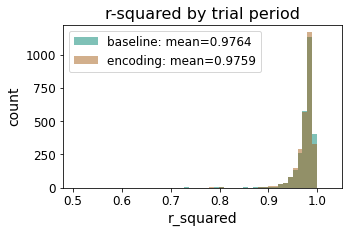

In [10]:
# plot histogram of r-squared values (baseline v. encoding)

# compute mena for each condition
r2_0 = df.loc[df['window']=='pre', 'r_squared'].values
r2_1 = df.loc[df['window']=='post', 'r_squared'].values

# plot histogram
fig, ax = plt.subplots(1,1, figsize=[5,3])
ax.hist(r2_0, bins=bin_edges, alpha=0.5, color=colors[0], label=f'baseline: mean={np.nanmean(r2_0):.4f}')
ax.hist(r2_1, bins=bin_edges, alpha=0.5, color=colors[1], label=f'encoding: mean={np.nanmean(r2_1):.4f}')
ax.set(xlabel="r_squared", ylabel="count")
ax.set_title("r-squared by trial period")
ax.set_xlim([np.min(df['r_squared'])-0.05, 1.05])
ax.legend()
plt.show()

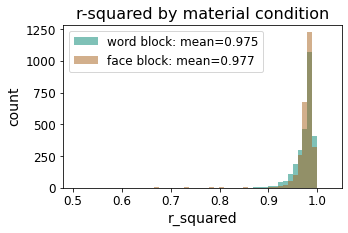

In [11]:
# plot histogram of r-squared values (word v. face)

# compute mean for each condition
r2_0 = df.loc[df['material']=='words', 'r_squared'].values
r2_1 = df.loc[df['material']=='faces', 'r_squared'].values

# plot histogram
fig, ax = plt.subplots(1,1, figsize=[5,3])
ax.hist(r2_0, bins=bin_edges, alpha=0.5, color=colors[0], label=f'word block: mean={np.nanmean(r2_0):.3f}')
ax.hist(r2_1, bins=bin_edges, alpha=0.5, color=colors[1], label=f'face block: mean={np.nanmean(r2_1):.3f}')
ax.set(xlabel="r_squared", ylabel="count")
ax.set_title("r-squared by material condition")
ax.set_xlim([np.min(df['r_squared'])-0.05, 1.05])
ax.legend()
plt.show()

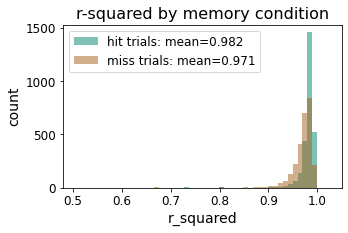

In [12]:
# plot histogram of r-squared values (hit v. miss)

# compute mean for each condition
r2_0 = df.loc[df['memory']=='hit', 'r_squared'].values
r2_1 = df.loc[df['memory']=='miss', 'r_squared'].values

# plot histogram
fig, ax = plt.subplots(1,1, figsize=[5,3])
ax.hist(r2_0, bins=bin_edges, alpha=0.5, color=colors[0], label=f'hit trials: mean={np.nanmean(r2_0):.3f}')
ax.hist(r2_1, bins=bin_edges, alpha=0.5, color=colors[1], label=f'miss trials: mean={np.nanmean(r2_1):.3f}')
ax.set(xlabel="r_squared", ylabel="count")
ax.set_title("r-squared by memory condition")
ax.set_xlim([np.min(df['r_squared'])-0.05, 1.05])
ax.legend()
plt.show()

### 3. Distribution of number-of-peaks detected
distributions of number-of-peaks detected (which, I understand, is a free parameter), etc. 

Response: The maximum number of peaks in the model is a free parameter of the spectral parameterization method. For all analyses in this manuscript, the 'max_n_peaks' argument was set to 4. If the number of peaks is not limited, the fitting algorithm may overfit the data (reducing error in the model by fitting Gaussians to noise in the spectrum). In this dataset, given the other parameters (peak threshold = 3 standard deviations), the maximum (4 peaks) was only detected for 1.4% of spectra fit. Most commonly (43%) a single peak was detected, and often (22%) no peaks met the threshold criteria.

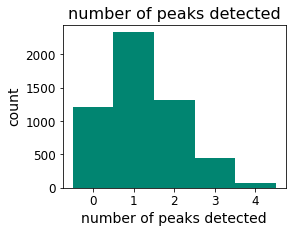

1    0.433172
2    0.244602
0    0.226173
3    0.081720
4    0.014334
Name: n_peaks, dtype: float64


In [13]:
# plot histogram of r-squared values (all conditions combined)

# plot
fig, ax = plt.subplots(1,1, figsize=[4,3])
bin_edges = np.linspace(0,5,6) -0.5
ax.hist(df['n_peaks'], bins=bin_edges, color=colors[0])
ax.set(xlabel="number of peaks detected", ylabel="count")
ax.set_title("number of peaks detected")
ax.set_xticks(bin_edges[:-1]+0.5)
plt.show()

# print counts / percentage
print(df['n_peaks'].value_counts() / len(df))